# Linear Elastic Console in 3d

In [12]:
from linkeddeepdict import LinkedDeepDict
from neumann.array import minmax

summary = LinkedDeepDict()


def add_to_summary(tag, t, dofsol, description=None):
    summary[tag]['t'] = t
    summary[tag]['minmax'] = minmax(dofsol)
    if description is not None:
        summary[tag]['description'] = description

In [13]:
import numpy as np
from polymesh.grid import gridH8 as grid
from sigmaepsilon.solid import Structure, PointData, FemMesh
from polymesh.space import PointCloud, StandardFrame
from sigmaepsilon.solid.fem.cells import H8
from neumann.array import repeat, minmax
from time import time
# input data
size = Lx, Ly, Lz = (20, 2, 2)
shape = nx, ny, nz = (40, 4, 4)
F = -10  # value of the load at the free end
E = 12000.  # Young's mpdulus
nu = 0.2  # Poisson's ratio
# generate grid
gridparams = {
    'size': size,
    'shape': shape,
    'origo': (0, 0, 0),
    'start': 0
}
coords, topo = grid(**gridparams)
# place the origo to the center of the cross section
# at the support
pc = PointCloud(coords)
pc.centralize()
dx = pc.bounds()[0, 0]
pc.move(np.array([-dx, 0., 0.]))
coords = pc.show()
# istoropic material
A = np.array([
    [1, nu, nu, 0, 0, 0],
    [nu, 1, nu, 0, 0, 0],
    [nu, nu, 1, 0, 0, 0],
    [0., 0, 0, (1-nu)/2, 0, 0],
    [0., 0, 0, 0, (1-nu)/2, 0],
    [0., 0, 0, 0, 0, (1-nu)/2]]) * (E / (1-nu**2))
# fix points at x==0
cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 6), dtype=bool)
fixity[ebcinds, :] = True
fixity[:, 3:] = True
# unit vertical load at (Lx, 0, 0)
iF = pc.id_of_closest([Lx, 0., 0.])
loads = np.zeros((coords.shape[0], 6))
loads[iF, 2] = F
# pointdata
GlobalFrame = StandardFrame(dim=3)
pd = PointData(coords=coords, frame=GlobalFrame,
               loads=loads, fixity=fixity)
# celldata
frames = repeat(GlobalFrame.show(), topo.shape[0])
cd = H8(topo=topo, frames=frames)
# set up mesh and structure
mesh = FemMesh(pd, cd, model=A, frame=GlobalFrame)
structure = Structure(mesh=mesh)
# solve
_t = time()
structure.linear_static_analysis()
dt = time() - _t
dofsol = structure.nodal_dof_solution()
add_to_summary('H8-6dof', dt, dofsol)

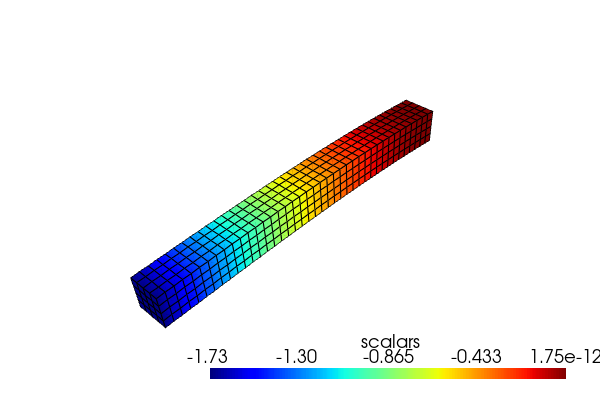

In [14]:
structure.mesh.pd['x'] = coords + dofsol[:, :3]
structure.mesh.pd['scalars'] = dofsol[:, 2]
mesh.pvplot(notebook=True, window_size=(600, 400), cmap='jet',
            jupyter_backend='static', scalars='scalars')


In [15]:
from sigmaepsilon.solid import SolidMesh
# pointdata
fixity = fixity[:, :3]
loads = loads[:, :3]
pd = PointData(coords=coords, frame=GlobalFrame,
               loads=loads, fixity=fixity)
# celldata
frames = repeat(GlobalFrame.show(), topo.shape[0])
cd = H8(topo=topo, frames=frames)
# set up mesh and structure
mesh = SolidMesh(pd, cd, model=A, frame=GlobalFrame)
structure = Structure(mesh=mesh)
# solve
_t = time()
structure.linear_static_analysis()
dt = time() - _t
dofsol = structure.nodal_dof_solution()
add_to_summary('H8-3dof', dt, dofsol)

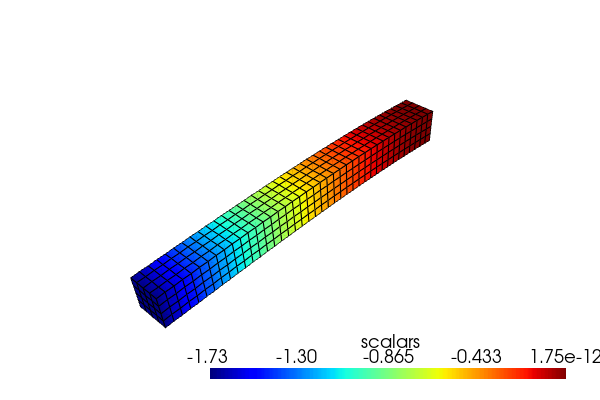

In [16]:
structure.mesh.pd['x'] = coords + dofsol[:, :3]
structure.mesh.pd['scalars'] = dofsol[:, 2]
mesh.pvplot(notebook=True, window_size=(600, 400), cmap='jet',
            jupyter_backend='static', scalars='scalars')


In [17]:
from polymesh.topo.tr import H8_to_H27
from polymesh.space import index_of_closest_point
from sigmaepsilon.solid.fem.cells import H27
# pointdata
coords, topo = H8_to_H27(coords, topo)
# fix points at x==0
cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 3), dtype=bool)
fixity[ebcinds, :] = True
# unit vertical load at (Lx, 0, 0)
iF = index_of_closest_point(coords, np.array([Lx, 0., 0.]))
loads = np.zeros((coords.shape[0], 3))
loads[iF, 2] = F
#pointdata
pd = PointData(coords=coords, frame=GlobalFrame,
               loads=loads, fixity=fixity)
# celldata
cd = H27(topo=topo, frames=GlobalFrame)
# set up mesh and structure
mesh = SolidMesh(pd, cd, model=A, frame=GlobalFrame)
structure = Structure(mesh=mesh)
# solve
_t = time()
structure.linear_static_analysis()
dt = time() - _t
dofsol = structure.nodal_dof_solution()
add_to_summary('H27-3dof', dt, dofsol)

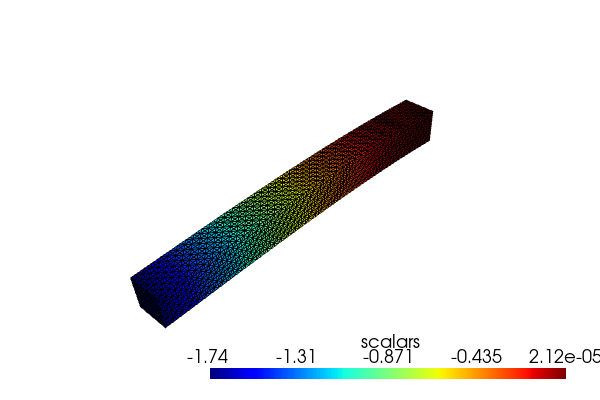

In [18]:
structure.mesh.pd['x'] = coords + dofsol[:, :3]
structure.mesh.pd['scalars'] = dofsol[:, 2]
mesh.pvplot(notebook=True, window_size=(600, 400), cmap='jet',
            jupyter_backend='static', scalars='scalars')

In [19]:
from polymesh.topo.tr import H8_to_TET4, TET4_to_TET10
from polymesh.space import index_of_closest_point
from sigmaepsilon.solid.fem.cells import TET4
# pointdata
coords, topo = H8_to_TET4(*grid(**gridparams))
# fix points at x==0
cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 3), dtype=bool)
fixity[ebcinds, :] = True
# unit vertical load at (Lx, 0, 0)
iF = index_of_closest_point(coords, np.array([Lx, 0., 0.]))
loads = np.zeros((coords.shape[0], 3))
loads[iF, 2] = F
#pointdata
pd = PointData(coords=coords, frame=GlobalFrame,
               loads=loads, fixity=fixity)
# celldata
cd = TET4(topo=topo, frames=GlobalFrame)
# set up mesh and structure
mesh = SolidMesh(pd, cd, model=A, frame=GlobalFrame)
structure = Structure(mesh=mesh)
# solve
_t = time()
structure.linear_static_analysis()
dt = time() - _t
dofsol = structure.nodal_dof_solution()
add_to_summary('TET4-3dof', dt, dofsol)

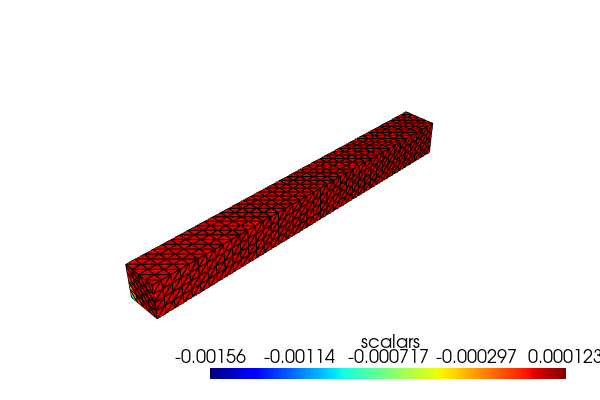

In [20]:
structure.mesh.pd['x'] = coords + dofsol[:, :3]
structure.mesh.pd['scalars'] = dofsol[:, 2]
mesh.pvplot(notebook=True, window_size=(600, 400), cmap='jet',
            jupyter_backend='static', scalars='scalars')

In [21]:
from polymesh.topo.tr import TET4_to_TET10
from polymesh.space import index_of_closest_point
from sigmaepsilon.solid.fem.cells import TET10
# generate shape functions
shp, dshp, shpf, shpmf, dshpf = TET10.generate_shape_functions()
TET10.shpfnc = shpf
TET10.shpmfnc = shpmf
TET10.dshpfnc = dshpf
# pointdata
coords, topo = TET4_to_TET10(coords, topo)
# fix points at x==0
cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 3), dtype=bool)
fixity[ebcinds, :] = True
# unit vertical load at (Lx, 0, 0)
iF = index_of_closest_point(coords, np.array([Lx, 0., 0.]))
loads = np.zeros((coords.shape[0], 3))
loads[iF, 2] = F
#pointdata
pd = PointData(coords=coords, frame=GlobalFrame,
               loads=loads, fixity=fixity)
# celldata
cd = TET10(topo=topo, frames=GlobalFrame)
# set up mesh and structure
mesh = SolidMesh(pd, cd, model=A, frame=GlobalFrame)
structure = Structure(mesh=mesh)
# solve
_t = time()
structure.linear_static_analysis()
dt = time() - _t
dofsol = structure.nodal_dof_solution()
add_to_summary('TET10-3dof', dt, dofsol)

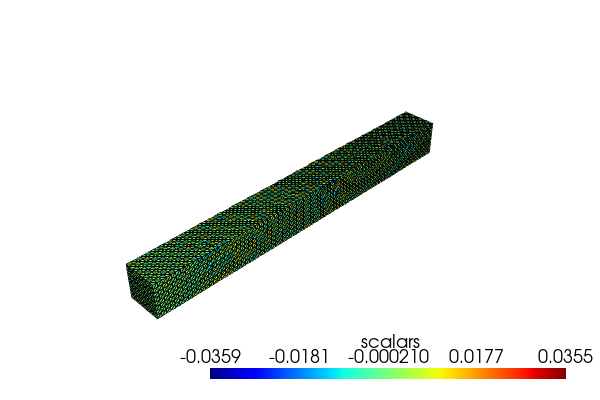

In [22]:
structure.mesh.pd['x'] = coords + dofsol[:, :3]
structure.mesh.pd['scalars'] = dofsol[:, 2]
mesh.pvplot(notebook=True, window_size=(600, 400), cmap='jet',
            jupyter_backend='static', scalars='scalars')